In [21]:
import pandas as pd
import re
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English



In [281]:
new_train_set = pd.read_csv("new_data/train_all.csv")
new_val_set = pd.read_csv("new_data/val_all.csv")


old_train_set = pd.read_csv("data/train_all.csv")
old_val_set = pd.read_csv("data/val_all.csv")

In [282]:
sum(new_val_set['requester_received_pizza'])/len(new_val_set)

0.580110497237569

In [283]:
sum(new_train_set['requester_received_pizza'])/len(new_train_set)

0.5795873249815771

In [153]:
nlp = spacy.load('en')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')


punctuations = string.punctuation


stop_words = spacy.lang.en.stop_words.STOP_WORDS

parser = English()

def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [154]:




def get_datasets(type='new'):
    if type == 'new':
        train_data = new_train_set['request_text'].apply(spacy_tokenizer)
        train_target = new_train_set['requester_received_pizza']
        val_data = new_val_set['request_text'].apply(spacy_tokenizer)
        val_target = new_val_set['requester_received_pizza']
    else:
        train_data = old_train_set['request_text_edit_aware'].apply(spacy_tokenizer)
        train_target = old_train_set['requester_received_pizza']
        val_data = old_val_set['request_text_edit_aware'].apply(spacy_tokenizer)
        val_target = old_val_set['requester_received_pizza']
        
    return train_data, train_target, val_data, val_target

In [155]:
train_data, train_target, val_data, val_target = get_datasets()

In [156]:
train_data[0]

['went',
 'clinic',
 'doctor',
 'sick',
 '10',
 'days',
 'pizza',
 'spent',
 '27.77',
 'counter',
 'meds',
 'home',
 'pick',
 'prescription',
 'sudafed',
 'supposed',
 'food',
 'honestly',
 'feel',
 'cooking']

In [285]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input, Bidirectional
from keras.optimizers import RMSprop



from matplotlib import pyplot as plt


def evaluate_lstm( train_data, train_target, val_data, val_target):

        
        MAX_NB_WORDS = 50000
        # Max number of words in each complaint.
        MAX_SEQUENCE_LENGTH = 250
        # This is fixed.
        EMBEDDING_DIM = 100
        tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
        tokenizer.fit_on_texts(train_data)
        word_index = tokenizer.word_index
        print('Found %s unique tokens.' % len(word_index))
    
    
        X_train = tokenizer.texts_to_sequences(train_data)
        X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
        print('Shape of data tensor:', X_train.shape)
    
    
        X_val = tokenizer.texts_to_sequences(val_data)
        X_val = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)
        print('Shape of data tensor:', X_val.shape)
    
        Y_train =  train_target
        print('Shape of label tensor:', Y_train.shape)
    
        Y_val =  val_target
        print('Shape of label tensor:', Y_val.shape)
        
        
#         inputs = Input(name='inputs',shape=[MAX_SEQUENCE_LENGTH])
#         layer = Embedding(MAX_NB_WORDS,150,input_length=MAX_SEQUENCE_LENGTH)(inputs)
#         layer = LSTM(64)(layer)
#         layer = Dense(256,name='FC1')(layer)
#         layer = Activation('relu')(layer)
#         layer = Dropout(0.5)(layer)
#         layer = Dense(2,name='softmax')(layer)
#         model = Model(inputs=inputs,outputs=layer)
        
#         model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

#         model = Sequential()
#         model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
#         model.add(SpatialDropout1D(0.2))
#         model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
#         model.add(Dense(2, activation='softmax'))
#         model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#         print(model.summary())

          
        model = Sequential()
        model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
        model.add(SpatialDropout1D(0.2))
        model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        print(model.summary())
    
    
    
#         model = Sequential()
#         model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
#         model.add(SpatialDropout1D(0.2))
#         model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
#         model.add(Dense(2, activation='softmax'))
#         model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#         print(model.summary())

#         sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
#         embedded_sequences= Embedding( MAX_NB_WORDS,100,input_length=MAX_SEQUENCE_LENGTH)(sequence_input)
#         l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
#         preds = Dense(2, activation='softmax')(l_lstm)
#         model = Model(sequence_input, preds)
#         model.compile(loss='categorical_crossentropy',optimizer='rmsprop',  metrics=['acc'])
    
        epochs = 10
        batch_size = 64

        history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val),callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        #accr = model.evaluate(X_val,Y_val)
       # print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
        
        return history
        
        

        
    
    

In [286]:
X_train.shape[1]

250

In [287]:
history = evaluate_lstm(train_data, train_target, val_data, val_target)

Found 9816 unique tokens.
Shape of data tensor: (2714, 250)
Shape of data tensor: (905, 250)
Shape of label tensor: (2714,)
Shape of label tensor: (905,)
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_65 (Embedding)     (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_42 (Spatia (None, 250, 100)          0         
_________________________________________________________________
lstm_64 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 101       
Total params: 5,080,501
Trainable params: 5,080,501
Non-trainable params: 0
_________________________________________________________________
None
Train on 2714 samples, validate on 905 samples
Epoch 1/10
2714/2714 [=============

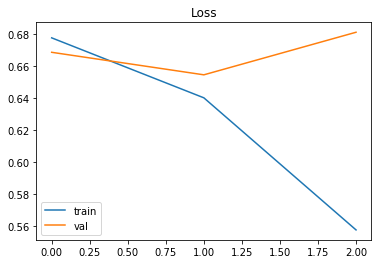

In [288]:
from matplotlib import pyplot as plt



plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [31]:
train_data[0]

'went clinic doctor ive sick 10 days pizza spent 2777 counter meds didnt home pick prescription sudafedim supposed food honestly dont feel cooking'

In [64]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_data)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11239 unique tokens.


In [65]:

X_train = tokenizer.texts_to_sequences(train_data)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train.shape)

Shape of data tensor: (2714, 250)


In [66]:

X_val = tokenizer.texts_to_sequences(val_data)
X_val = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_val.shape)

Shape of data tensor: (905, 250)


In [67]:
Y_train =  pd.get_dummies(train_target)
print('Shape of label tensor:', Y_train.shape)

Shape of label tensor: (2714, 2)


In [68]:
Y_val =  pd.get_dummies(val_target)
print('Shape of label tensor:', Y_val.shape)

Shape of label tensor: (905, 2)


In [69]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D


model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 5,080,602
Trainable params: 5,080,602
Non-trainable params: 0
_________________________________________________________________
None


In [75]:
from keras.callbacks import EarlyStopping

epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 2171 samples, validate on 543 samples
Epoch 1/10
2171/2171 [==============================] - 12s 5ms/step - loss: 0.0817 - accuracy: 0.9733 - val_loss: 0.8410 - val_accuracy: 0.7459
Epoch 2/10
2171/2171 [==============================] - 13s 6ms/step - loss: 0.0534 - accuracy: 0.9857 - val_loss: 0.8877 - val_accuracy: 0.7403
Epoch 3/10
2171/2171 [==============================] - 12s 6ms/step - loss: 0.0351 - accuracy: 0.9889 - val_loss: 0.9345 - val_accuracy: 0.7514
Epoch 4/10
2171/2171 [==============================] - 11s 5ms/step - loss: 0.0263 - accuracy: 0.9940 - val_loss: 1.1167 - val_accuracy: 0.7514


In [76]:
accr = model.evaluate(X_val,Y_val)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

905/905 [==============================] - 2s 2ms/step
Test set
  Loss: 2.028
  Accuracy: 0.540


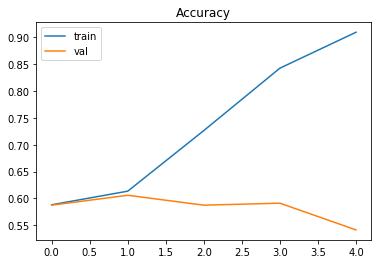

In [216]:

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()